In [8]:
# The following pytorch code is based on
# https://github.com/snowbbbb/code-for-Global-Convergence-of-Over-parameterized-Deep-Equilibrium-Models

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import os
import torch.nn.functional as F
import random
from torch.utils.data import TensorDataset
import torch.autograd as autograd
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

'''
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)　　 
torch.cuda.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
'''

'\nSEED = 2\ntorch.manual_seed(SEED)\nrandom.seed(SEED)\u3000\u3000 \ntorch.cuda.manual_seed(SEED) \ntorch.backends.cudnn.deterministic = True\n'

In [75]:
root_train = '/Users/lantruong/Dataset/CIFAR10/'
trainTransform = transforms.Compose([transforms.Grayscale(1),
                                transforms.ToTensor()])
                               
trainset_full = torchvision.datasets.CIFAR10(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets=='airplane')
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset0 = torch.utils.data.Subset(trainset_full, range(500))

trainset_full = torchvision.datasets.CIFAR10(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets=='automobile')
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset1 = torch.utils.data.Subset(trainset_full, range(500))

trainset=torch.utils.data.ConcatDataset([trainset0,trainset1])


Files already downloaded and verified
Files already downloaded and verified


In [77]:
########################################################################
# Download and define the training set.

samplesize = 10000
netDepth = 2

trainloader = torch.utils.data.DataLoader(trainset_full, batch_size=len(trainset), shuffle=True)
batchsize=1000
dataiter = iter(trainloader)
images, labels =next(dataiter)
images=torch.flatten(images,start_dim=1)
images = F.normalize(images, p=2, dim=1)
allLabel =torch.rand(1000)
train_ids = TensorDataset(images, allLabel)
trainloader = torch.utils.data.DataLoader(dataset=train_ids, batch_size=len(train_ids), shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_size=1

In [78]:
def FPiter(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0):
    #Anderson acceleration for fixed point iteration
    bsz, D = x0.shape
    X = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    X[:, 0], F[:, 0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1
    y = torch.zeros(bsz, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:, :n] - X[:, :n]
        H[:, 1:n + 1, 1:n + 1] = torch.bmm(G, G.transpose(1, 2)) + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[
            None]
        alpha = torch.linalg.solve(H[:, :n + 1, :n + 1],y[:, :n + 1])[:, 1:n + 1, 0]  # (bsz x n)

        X[:, k % m] = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        F[:, k % m] = f(X[:, k % m].view_as(x0)).view(bsz, -1)
        res.append((F[:, k % m] - X[:, k % m]).norm().item() / (1e-5 + F[:, k % m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:, k % m].view_as(x0), res

In [79]:
class Net(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.sigmoid(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [80]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z: self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z, x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)

        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [81]:
def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc * nx * ny)
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs, nc, nx, ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data

In [82]:
def setup_and_train(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = Net(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot   

In [88]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=5000

loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(2.6747e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch 34.34s | loss 891.91 
lambda_min tensor(2.6013e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch 34.12s | loss 501.23 
lambda_min tensor(2.4122e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch 33.96s | loss 301.37 
lambda_min tensor(2.2300e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch 33.79s | loss 199.12 
lambda_min tensor(2.1412e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch 34.09s | loss 146.81 
lambda_min tensor(2.3913e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch 33.76s | loss 91.92 
lambda_min tensor(2.0788e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch 34.39s | loss 91.92 
lambda_min tensor(2.7588e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch 34.03s | loss 91.92 
lambda_min tensor(2.3060e-05-2.1716e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch 33.65s | loss 91.91 
lambda_min tensor(2.3681e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch 33.78s | loss 91.91 
lambda_min tensor(1.9223e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch 33.79s | loss 91.91 
lambda_min tens

lambda_min tensor(2.3334e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch 33.76s | loss 91.80 
lambda_min tensor(2.5287e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch 33.75s | loss 91.80 
lambda_min tensor(1.8928e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch 34.01s | loss 91.80 
lambda_min tensor(2.2395e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch 33.80s | loss 91.80 
lambda_min tensor(4.0568e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch 34.08s | loss 91.79 
lambda_min tensor(2.6472e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 10

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch 34.22s | loss 91.69 
lambda_min tensor(2.9423e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch 33.73s | loss 91.69 
lambda_min tensor(2.6711e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch 33.71s | loss 91.69 
lambda_min tensor(2.1331e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch 33.76s | loss 91.69 
lambda_min tensor(2.2668e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch 33.70s | loss 91.68 
lambda_min tensor(2.2721e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch 33.77s | loss 91.68 
lambda_min tensor(1.995

lambda_min tensor(2.4126e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch 33.75s | loss 91.58 
lambda_min tensor(2.4488e-05-6.6237e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch 33.89s | loss 91.58 
lambda_min tensor(2.8550e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch 33.77s | loss 91.58 
lambda_min tensor(2.4992e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch 34.11s | loss 91.58 
lambda_min tensor(2.7429e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch 33.81s | loss 91.57 
lambda_min tensor(2.1910e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of 

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 238 | time / epoch 3907.67s | loss 91.48 
lambda_min tensor(2.7995e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch 5191.26s | loss 91.47 
lambda_min tensor(2.3217e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch 2931.69s | loss 91.47 
lambda_min tensor(2.5275e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 241 | time / epoch 34.22s | loss 91.47 
lambda_min tensor(2.3374e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 242 | time / epoch 33.86s | loss 91.47 
lambda_min tensor(3.4380e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch 33.74s | loss 91.47 
lambda_min tensor

lambda_min tensor(2.3517e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch 33.82s | loss 91.37 
lambda_min tensor(2.4275e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch 33.64s | loss 91.37 
lambda_min tensor(2.1713e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 288 | time / epoch 33.84s | loss 91.37 
lambda_min tensor(2.7225e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 289 | time / epoch 34.02s | loss 91.36 
lambda_min tensor(2.7376e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 290 | time / epoch 34.50s | loss 91.36 
lambda_min tensor(2.2879e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 29

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 333 | time / epoch 33.64s | loss 91.27 
lambda_min tensor(1.7967e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch 33.98s | loss 91.27 
lambda_min tensor(2.0689e-05-5.3591e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 335 | time / epoch 33.65s | loss 91.27 
lambda_min tensor(2.5358e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 336 | time / epoch 33.71s | loss 91.26 
lambda_min tensor(2.5933e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 337 | time / epoch 33.77s | loss 91.26 
lambda_min tensor(2.2995e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 338 | time / epoch 33.91s | loss 91.26 
lambda_min tens

lambda_min tensor(2.5974e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch 33.79s | loss 91.17 
lambda_min tensor(2.4279e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 382 | time / epoch 33.85s | loss 91.17 
lambda_min tensor(7.5657e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 383 | time / epoch 33.98s | loss 91.17 
lambda_min tensor(2.7980e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 384 | time / epoch 33.86s | loss 91.16 
lambda_min tensor(2.7091e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 385 | time / epoch 33.91s | loss 91.16 
lambda_min tensor(2.7232e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 38

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 428 | time / epoch 33.85s | loss 91.08 
lambda_min tensor(1.7730e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 429 | time / epoch 33.66s | loss 91.07 
lambda_min tensor(2.5531e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 430 | time / epoch 33.83s | loss 91.07 
lambda_min tensor(2.2570e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 431 | time / epoch 33.69s | loss 91.07 
lambda_min tensor(2.3637e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 432 | time / epoch 34.57s | loss 91.07 
lambda_min tensor(1.8547e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 433 | time / epoch 33.72s | loss 91.07 
lambda_min tensor(2.314

lambda_min tensor(4.2207e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 476 | time / epoch 33.85s | loss 90.98 
lambda_min tensor(2.3182e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 477 | time / epoch 33.58s | loss 90.98 
lambda_min tensor(1.8350e-05-1.0183e-07j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 478 | time / epoch 33.52s | loss 90.98 
lambda_min tensor(2.6956e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 479 | time / epoch 33.76s | loss 90.97 
lambda_min tensor(2.4316e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 480 | time / epoch 33.87s | loss 90.97 
lambda_min tensor(2.8266e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of 

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch 33.84s | loss 90.89 
lambda_min tensor(2.4496e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 524 | time / epoch 33.71s | loss 90.89 
lambda_min tensor(2.4160e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 525 | time / epoch 33.58s | loss 90.89 
lambda_min tensor(2.9750e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 526 | time / epoch 33.88s | loss 90.88 
lambda_min tensor(2.3227e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 527 | time / epoch 33.68s | loss 90.88 
lambda_min tensor(2.3597e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 528 | time / epoch 33.78s | loss 90.88 
lambda_min tensor(2.382

lambda_min tensor(2.0657e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch 34.04s | loss 90.80 
lambda_min tensor(2.7381e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch 33.73s | loss 90.80 
lambda_min tensor(2.0963e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 573 | time / epoch 33.57s | loss 90.79 
lambda_min tensor(4.7591e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 574 | time / epoch 33.89s | loss 90.79 
lambda_min tensor(2.6668e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 575 | time / epoch 33.71s | loss 90.79 
lambda_min tensor(2.2374e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 57

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch 33.96s | loss 90.71 
lambda_min tensor(2.6021e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch 33.97s | loss 90.71 
lambda_min tensor(2.2034e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 620 | time / epoch 33.87s | loss 90.71 
lambda_min tensor(2.1962e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 621 | time / epoch 34.27s | loss 90.71 
lambda_min tensor(2.9766e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 622 | time / epoch 34.11s | loss 90.70 
lambda_min tensor(2.5362e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 623 | time / epoch 33.78s | loss 90.70 
lambda_min tensor(3.065

lambda_min tensor(2.1463e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch 33.81s | loss 90.62 
lambda_min tensor(2.0371e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch 34.27s | loss 90.62 
lambda_min tensor(2.5855e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 668 | time / epoch 33.74s | loss 90.62 
lambda_min tensor(2.7537e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 669 | time / epoch 33.97s | loss 90.62 
lambda_min tensor(5.0627e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 670 | time / epoch 33.86s | loss 90.62 
lambda_min tensor(1.9972e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 67

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch 33.58s | loss 90.54 
lambda_min tensor(2.4757e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch 33.73s | loss 90.54 
lambda_min tensor(2.2700e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 715 | time / epoch 33.73s | loss 90.54 
lambda_min tensor(2.0903e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 716 | time / epoch 33.73s | loss 90.53 
lambda_min tensor(2.7008e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 717 | time / epoch 34.02s | loss 90.53 
lambda_min tensor(3.1529e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 718 | time / epoch 33.88s | loss 90.53 
lambda_min tensor(2.593

lambda_min tensor(2.7947e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch 33.56s | loss 90.46 
lambda_min tensor(2.2092e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 762 | time / epoch 33.69s | loss 90.45 
lambda_min tensor(2.2484e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 763 | time / epoch 33.78s | loss 90.45 
lambda_min tensor(2.7192e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 764 | time / epoch 33.79s | loss 90.45 
lambda_min tensor(2.3695e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 765 | time / epoch 33.67s | loss 90.45 
lambda_min tensor(2.1312e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 76

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 808 | time / epoch 34.18s | loss 90.38 
lambda_min tensor(2.3831e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 809 | time / epoch 34.26s | loss 90.37 
lambda_min tensor(2.7261e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 810 | time / epoch 34.08s | loss 90.37 
lambda_min tensor(2.6197e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 811 | time / epoch 34.18s | loss 90.37 
lambda_min tensor(2.1640e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 812 | time / epoch 33.91s | loss 90.37 
lambda_min tensor(2.1210e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 813 | time / epoch 34.13s | loss 90.37 
lambda_min tensor(3.093

lambda_min tensor(2.7070e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 856 | time / epoch 33.92s | loss 90.30 
lambda_min tensor(2.1969e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 857 | time / epoch 34.14s | loss 90.29 
lambda_min tensor(2.4596e-05-3.8044e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 858 | time / epoch 33.54s | loss 90.29 
lambda_min tensor(2.6864e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 859 | time / epoch 33.51s | loss 90.29 
lambda_min tensor(2.3791e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 860 | time / epoch 33.66s | loss 90.29 
lambda_min tensor(2.4910e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of 

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 903 | time / epoch 34.24s | loss 90.22 
lambda_min tensor(4.1906e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 904 | time / epoch 34.03s | loss 90.22 
lambda_min tensor(2.3241e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 905 | time / epoch 33.74s | loss 90.22 
lambda_min tensor(2.2337e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 906 | time / epoch 33.79s | loss 90.21 
lambda_min tensor(2.5024e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 907 | time / epoch 33.62s | loss 90.21 
lambda_min tensor(2.3786e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 908 | time / epoch 33.55s | loss 90.21 
lambda_min tensor(2.137

lambda_min tensor(2.3012e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 951 | time / epoch 33.97s | loss 90.14 
lambda_min tensor(4.0565e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 952 | time / epoch 34.00s | loss 90.14 
lambda_min tensor(1.8608e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 953 | time / epoch 33.62s | loss 90.14 
lambda_min tensor(2.3165e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 954 | time / epoch 34.11s | loss 90.14 
lambda_min tensor(2.5459e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 955 | time / epoch 33.99s | loss 90.14 
lambda_min tensor(1.9149e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 95

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 998 | time / epoch 34.32s | loss 90.07 
lambda_min tensor(2.4408e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 999 | time / epoch 33.86s | loss 90.07 
lambda_min tensor(3.7506e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1000 | time / epoch 33.92s | loss 90.07 
lambda_min tensor(2.0887e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1001 | time / epoch 33.49s | loss 90.06 
lambda_min tensor(2.5376e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1002 | time / epoch 34.13s | loss 90.06 
lambda_min tensor(2.5196e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1003 | time / epoch 33.67s | loss 90.06 
lambda_min tensor(2

lambda_min tensor(2.5382e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1046 | time / epoch 34.01s | loss 89.99 
lambda_min tensor(3.1387e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1047 | time / epoch 33.83s | loss 89.99 
lambda_min tensor(2.5701e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1048 | time / epoch 34.17s | loss 89.99 
lambda_min tensor(2.6334e-05-9.6271e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1049 | time / epoch 34.59s | loss 89.99 
lambda_min tensor(2.0217e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1050 | time / epoch 34.31s | loss 89.99 
lambda_min tensor(2.7244e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(4.8108e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1093 | time / epoch 34.44s | loss 89.92 
lambda_min tensor(2.7535e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1094 | time / epoch 33.58s | loss 89.92 
lambda_min tensor(2.5626e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1095 | time / epoch 34.22s | loss 89.92 
lambda_min tensor(2.8246e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1096 | time / epoch 33.74s | loss 89.92 
lambda_min tensor(1.9903e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1097 | time / epoch 33.99s | loss 89.92 
lambda_min tensor(5.0049e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.9724e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1140 | time / epoch 33.95s | loss 89.85 
lambda_min tensor(2.3628e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1141 | time / epoch 33.86s | loss 89.85 
lambda_min tensor(2.0430e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1142 | time / epoch 33.94s | loss 89.85 
lambda_min tensor(2.5692e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1143 | time / epoch 34.31s | loss 89.85 
lambda_min tensor(4.5359e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1144 | time / epoch 34.10s | loss 89.85 
lambda_min tensor(2.8792e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1187 | time / epoch 34.64s | loss 89.78 
lambda_min tensor(2.3755e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1188 | time / epoch 34.10s | loss 89.78 
lambda_min tensor(2.9318e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1189 | time / epoch 33.68s | loss 89.78 
lambda_min tensor(2.0597e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1190 | time / epoch 33.78s | loss 89.78 
lambda_min tensor(2.6127e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1191 | time / epoch 34.01s | loss 89.78 
lambda_min tensor(2.2850e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1192 | time / epoch 34.01s | loss 89.78 
lambda_min tensor

lambda_min tensor(2.3166e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1235 | time / epoch 34.48s | loss 89.71 
lambda_min tensor(1.9396e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1236 | time / epoch 33.67s | loss 89.71 
lambda_min tensor(2.7068e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1237 | time / epoch 33.52s | loss 89.71 
lambda_min tensor(2.7691e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1238 | time / epoch 33.87s | loss 89.71 
lambda_min tensor(2.7153e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1239 | time / epoch 33.85s | loss 89.71 
lambda_min tensor(2.3927e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.3008e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1282 | time / epoch 34.28s | loss 89.65 
lambda_min tensor(2.2920e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1283 | time / epoch 33.67s | loss 89.65 
lambda_min tensor(2.4600e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1284 | time / epoch 33.88s | loss 89.64 
lambda_min tensor(2.4706e-05-4.0037e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1285 | time / epoch 33.47s | loss 89.64 
lambda_min tensor(2.2706e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1286 | time / epoch 33.91s | loss 89.64 
lambda_min tensor(1.9504e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(2.2901e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1329 | time / epoch 33.80s | loss 89.58 
lambda_min tensor(2.5664e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1330 | time / epoch 33.90s | loss 89.58 
lambda_min tensor(2.6902e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1331 | time / epoch 33.81s | loss 89.58 
lambda_min tensor(2.7206e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1332 | time / epoch 33.65s | loss 89.58 
lambda_min tensor(3.5864e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1333 | time / epoch 34.50s | loss 89.58 
lambda_min tensor(1.9177e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.5862e-05-5.2275e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1376 | time / epoch 33.89s | loss 89.52 
lambda_min tensor(2.1246e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1377 | time / epoch 33.92s | loss 89.52 
lambda_min tensor(2.6859e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1378 | time / epoch 33.98s | loss 89.51 
lambda_min tensor(2.9951e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1379 | time / epoch 34.04s | loss 89.51 
lambda_min tensor(2.2858e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1380 | time / epoch 33.78s | loss 89.51 
lambda_min tensor(2.1454e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(2.2239e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1423 | time / epoch 34.76s | loss 89.45 
lambda_min tensor(2.7397e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1424 | time / epoch 33.92s | loss 89.45 
lambda_min tensor(2.9093e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1425 | time / epoch 33.77s | loss 89.45 
lambda_min tensor(2.2411e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1426 | time / epoch 33.90s | loss 89.45 
lambda_min tensor(1.9472e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1427 | time / epoch 33.92s | loss 89.45 
lambda_min tensor(2.3664e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.1804e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1470 | time / epoch 33.86s | loss 89.39 
lambda_min tensor(1.9801e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1471 | time / epoch 33.68s | loss 89.39 
lambda_min tensor(2.6392e-05-1.3147e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1472 | time / epoch 34.03s | loss 89.39 
lambda_min tensor(2.1310e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1473 | time / epoch 34.04s | loss 89.39 
lambda_min tensor(2.2340e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1474 | time / epoch 33.81s | loss 89.39 
lambda_min tensor(2.7804e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(1.9924e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1517 | time / epoch 33.85s | loss 89.33 
lambda_min tensor(3.0562e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1518 | time / epoch 33.74s | loss 89.33 
lambda_min tensor(2.0072e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1519 | time / epoch 34.14s | loss 89.33 
lambda_min tensor(2.1420e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1520 | time / epoch 34.07s | loss 89.33 
lambda_min tensor(2.6696e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1521 | time / epoch 33.98s | loss 89.32 
lambda_min tensor(1.9523e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.0554e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1564 | time / epoch 33.65s | loss 89.27 
lambda_min tensor(2.2483e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1565 | time / epoch 34.10s | loss 89.27 
lambda_min tensor(2.8389e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1566 | time / epoch 33.85s | loss 89.27 
lambda_min tensor(2.3409e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1567 | time / epoch 33.73s | loss 89.26 
lambda_min tensor(2.3469e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1568 | time / epoch 33.78s | loss 89.26 
lambda_min tensor(2.3345e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.5001e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1611 | time / epoch 33.79s | loss 89.21 
lambda_min tensor(2.3554e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1612 | time / epoch 33.55s | loss 89.21 
lambda_min tensor(2.6299e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1613 | time / epoch 33.75s | loss 89.21 
lambda_min tensor(2.6977e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1614 | time / epoch 33.52s | loss 89.20 
lambda_min tensor(2.1672e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1615 | time / epoch 33.52s | loss 89.20 
lambda_min tensor(2.3568e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1658 | time / epoch 33.83s | loss 89.15 
lambda_min tensor(2.7245e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1659 | time / epoch 34.27s | loss 89.15 
lambda_min tensor(2.1834e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1660 | time / epoch 33.65s | loss 89.15 
lambda_min tensor(2.5086e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1661 | time / epoch 34.22s | loss 89.15 
lambda_min tensor(2.5413e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1662 | time / epoch 33.56s | loss 89.14 
lambda_min tensor(2.4038e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1663 | time / epoch 33.79s | loss 89.14 
lambda_min tensor

lambda_min tensor(2.8138e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1706 | time / epoch 33.73s | loss 89.09 
lambda_min tensor(2.9745e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1707 | time / epoch 34.68s | loss 89.09 
lambda_min tensor(4.1719e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1708 | time / epoch 34.54s | loss 89.09 
lambda_min tensor(2.4753e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1709 | time / epoch 33.81s | loss 89.09 
lambda_min tensor(2.4270e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1710 | time / epoch 33.66s | loss 89.09 
lambda_min tensor(2.4821e-05-5.3183e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(2.1730e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch 33.96s | loss 89.03 
lambda_min tensor(2.2777e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1754 | time / epoch 33.84s | loss 89.03 
lambda_min tensor(2.5784e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1755 | time / epoch 33.61s | loss 89.03 
lambda_min tensor(1.9654e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1756 | time / epoch 33.93s | loss 89.03 
lambda_min tensor(2.2340e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1757 | time / epoch 33.89s | loss 89.03 
lambda_min tensor(2.7752e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.7446e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch 33.95s | loss 88.98 
lambda_min tensor(2.1260e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch 33.95s | loss 88.97 
lambda_min tensor(3.6839e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch 33.68s | loss 88.97 
lambda_min tensor(2.7025e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1803 | time / epoch 33.74s | loss 88.97 
lambda_min tensor(3.0538e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1804 | time / epoch 33.66s | loss 88.97 
lambda_min tensor(2.4866e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch 33.94s | loss 88.92 
lambda_min tensor(2.3311e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch 34.15s | loss 88.92 
lambda_min tensor(2.0391e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch 34.16s | loss 88.92 
lambda_min tensor(2.6032e-05-4.4048e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch 34.15s | loss 88.92 
lambda_min tensor(1.8804e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1851 | time / epoch 33.95s | loss 88.92 
lambda_min tensor(2.3819e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1852 | time / epoch 33.80s | loss 88.91 
lambda_mi

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch 33.70s | loss 88.86 
lambda_min tensor(1.8459e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch 33.93s | loss 88.86 
lambda_min tensor(2.8353e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch 33.88s | loss 88.86 
lambda_min tensor(2.4344e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch 33.81s | loss 88.86 
lambda_min tensor(2.3021e-05-4.1778e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch 33.78s | loss 88.86 
lambda_min tensor(2.4094e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch 34.68s | loss 88.86 
lambda_mi

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch 34.06s | loss 88.81 
lambda_min tensor(2.2463e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch 33.86s | loss 88.81 
lambda_min tensor(2.2961e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch 33.69s | loss 88.81 
lambda_min tensor(2.1603e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch 33.83s | loss 88.81 
lambda_min tensor(2.0893e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch 33.92s | loss 88.81 
lambda_min tensor(2.0996e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch 33.72s | loss 88.80 
lambda_min tensor

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch 33.92s | loss 88.76 
lambda_min tensor(1.7511e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch 33.91s | loss 88.76 
lambda_min tensor(1.9902e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch 33.77s | loss 88.75 
lambda_min tensor(2.3050e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch 33.95s | loss 88.75 
lambda_min tensor(2.0552e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch 34.47s | loss 88.75 
lambda_min tensor(2.7802e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch 33.92s | loss 88.75 
lambda_min tensor

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001

width=3000
loss_plot3000=setup_and_train(epochs, lr, 3000, Wstd)

width=4000
loss_plot4000=setup_and_train(epochs, lr, 4000, Wstd)

width=5000
loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


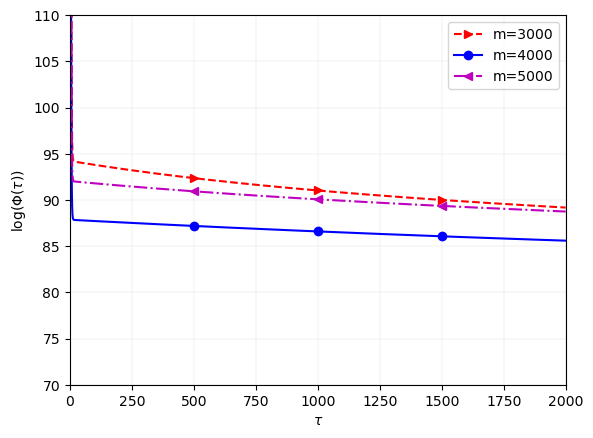

In [137]:
plt.figure(1)
plt.plot(range(epochs), loss_plot3000,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot4000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot5000,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['m=3000','m=4000','m=5000'])
plt.axis([0,2000,70,110])
plt.savefig('code_DEM_CIFAR10.pdf') 
plt.savefig('code_DEM_CIFAR10.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)



In [95]:
class NetReLU(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   #nn.normal的参数中std是标准差 正态分布N(u,d^2)  方差为d^2,标准差为d，


    def forward(self, z, x):
        y = F.relu(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [96]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetReLU(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000ReLU=setup_and_train(epochs, lr, 3000, Wstd)

In [102]:
class NetTANH(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.tanh(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [103]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetTANH(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000tanh=setup_and_train(epochs, lr, 3000, Wstd)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


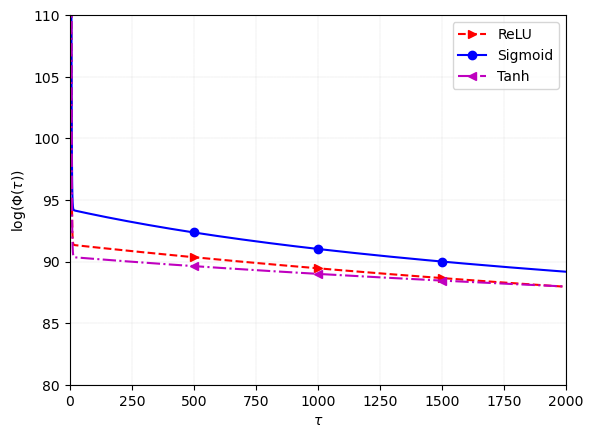

In [135]:
plt.figure(2)
plt.plot(range(epochs), loss_plot3000ReLU,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot3000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot3000tanh,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['ReLU','Sigmoid','Tanh'])
plt.savefig('L2loss_mnist_'+str(width)+'_'+str(Wstd)+'.png')
plt.axis([0,2000,80,110])
plt.savefig('code_DEM_comp_cifar.pdf') 
plt.savefig('code_DEM_comp_cifar.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)